In [9]:
import datetime as dt
import itertools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import numpy as np
from operator import itemgetter
import os
import pandas as pd
import scipy as ss
import scipy.stats
from sklearn.decomposition import PCA
import seaborn as sns; sns.set_style("ticks")


# These are RPKMs. 

data = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
              "data/get_homologs_output/C50_S90_e0_/run_C50_S90_e0__pan_C50_S90/"\
               "2018-02-26_pangenome_matrix_t0_crossRef.csv"
        
        
        
#DESeq2 normalized counts



figures_folder = "/Users/annasintsova/git_repos/HUTI-RNAseq/figures/in-patient-transcription-state/"


today = dt.datetime.today().strftime("%Y-%m-%d")



#Normalization Function
def invnorm(x):
    return scipy.stats.norm.ppf((x.rank() -0.5)/x.count())

def sample_label(strain, treat, join = " | "):
    return strain+join+treat

col1 = "#f34236"
col2 = "#d6c571"
col3 = "#88bc67"
col4 = "#2e8174"
col5 = "#143969"
colors = [col1, col2, col3, col4, col5]
ur = "URINE"
uti = "PATIENT"
join = " | "
# Based on saturation curves
strain_qual = {'good':["HM56", "HM14", "HM43", "HM54", "HM86"],
              'okay':["HM01", "HM03", "HM06", "HM68"],
              'so-so':["HM57", "HM17", "HM07" "HM60"],
              'bad': ["HM66"]}


data = pd.read_csv(data, index_col=0)
pan_mat = data.iloc[:,0:16]
count_mat = data.iloc[:,16:]
count_mat.dropna(inplace=True)
to_drop = [c for c in count_mat.columns if 'counts' in c or 'seq' in c]
count_mat = count_mat.drop(to_drop, axis =1)
df = count_mat.join(data['CFT073'])
df.set_index('CFT073', inplace=True)
df.sort_index(inplace=True)
col_names = sorted([tuple(c.split("_")) for c in df.columns], key=itemgetter(1,0))
col_names = ["_".join(c) for c in col_names]
df = df[col_names]

df.columns = [sample_label(c.split("_")[0], ur) if "UR" in c else sample_label(c.split("_")[0], uti) for c in df.columns]
cc_norm = df.apply(invnorm)

In [2]:
meta_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/Patient_meta_info.csv"

meta = pd.read_csv(meta_file, index_col=0)
meta.STRAIN = ["HM0"+s.split("HM")[1] if int(s.split("HM")[1]) < 10 else s for s in meta.STRAIN]
meta.MEDIA =[ur if m == "UR" else uti for m in meta.MEDIA ]
meta = meta[["STRAIN", "MEDIA", "PRED_PHYLO", "HISTORY"]]
meta.index = [meta.STRAIN + join + meta.MEDIA ]
#meta.to_csv(os.path.join(os.path.dirname(meta_file), "huti_patient_info_short.csv"))
meta

,STRAIN,MEDIA,PRED_PHYLO,HISTORY
HM01 | URINE,HM01,URINE,E,N
HM01 | PATIENT,HM01,PATIENT,E,N
HM03 | URINE,HM03,URINE,B1,N
HM03 | PATIENT,HM03,PATIENT,B1,N
HM06 | URINE,HM06,URINE,B2,N
HM06 | PATIENT,HM06,PATIENT,B2,N
HM07 | URINE,HM07,URINE,B1,Y
HM07 | PATIENT,HM07,PATIENT,B1,Y
HM14 | URINE,HM14,URINE,B1,Y
HM14 | PATIENT,HM14,PATIENT,B1,Y


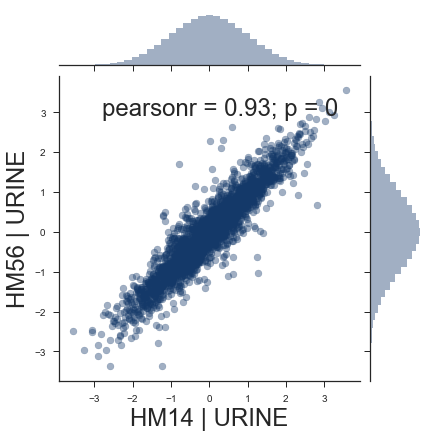

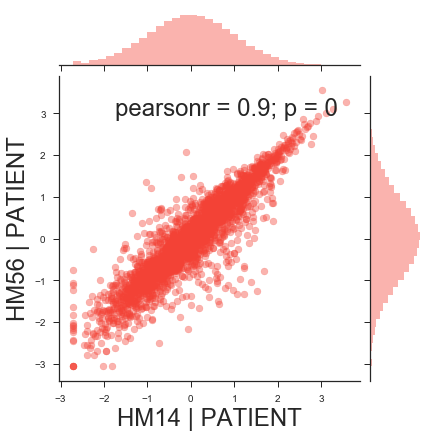

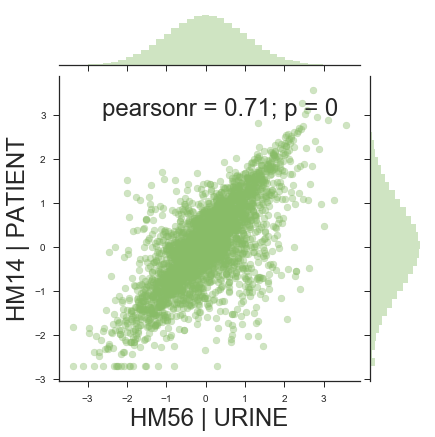

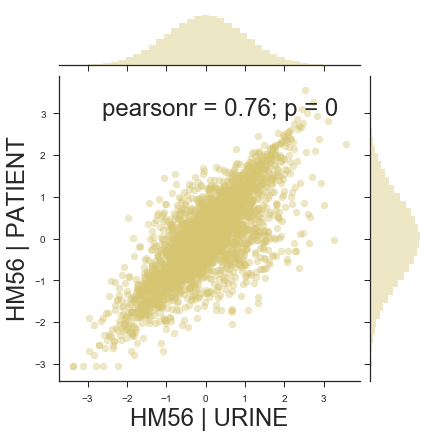

In [28]:
###
# Figure 2A: Example of gene expression correlation, using HM14 and HM56

hm14_ur = sample_label("HM14", ur)
hm14_uti = sample_label("HM14", uti)
hm56_ur = sample_label("HM56", ur)
hm56_uti = sample_label("HM56", uti)
FS = 24
# 1. UR vs UR 
matplotlib.rc('legend', fontsize=FS)

s = sns.jointplot(cc_norm[hm14_ur], cc_norm[hm56_ur], color= col5, alpha=0.4);
s.ax_joint.set_ylabel(s.ax_joint.get_ylabel(), fontsize=FS)
s.ax_joint.set_xlabel(s.ax_joint.get_xlabel(), fontsize=FS)
fn = os.path.join(figures_folder, today+"figure_2a_i.png")
s.savefig(filename=fn, dpi = 500, bbox_inches = "tight")
# 2. UTI vs UTI
s = sns.jointplot(cc_norm[hm14_uti], cc_norm[hm56_uti], color= col1, alpha=0.4);
s.ax_joint.set_ylabel(s.ax_joint.get_ylabel(), fontsize=FS)
s.ax_joint.set_xlabel(s.ax_joint.get_xlabel(), fontsize=FS)
fn = os.path.join(figures_folder, today+"figure_2a_ii.png")
s.savefig(filename=fn, dpi = 500, bbox_inches = "tight")
# 3. UR vs unmatched UTI
s = sns.jointplot(cc_norm[hm56_ur], cc_norm[hm14_uti], color= col3, alpha=0.4);
s.ax_joint.set_ylabel(s.ax_joint.get_ylabel(), fontsize=FS)
s.ax_joint.set_xlabel(s.ax_joint.get_xlabel(), fontsize=FS)
fn = os.path.join(figures_folder, today+"figure_2a_iii.png")
s.savefig(filename=fn, dpi = 500, bbox_inches = "tight")
# 4. UR vs UTI 2
s = sns.jointplot(cc_norm[hm56_ur], cc_norm[hm56_uti], color= col2, alpha=0.4);
s.ax_joint.set_ylabel(s.ax_joint.get_ylabel(), fontsize=FS)
s.ax_joint.set_xlabel(s.ax_joint.get_xlabel(), fontsize=FS)
fn = os.path.join(figures_folder, today+"figure_2a_iv.png")
s.savefig(filename=fn, dpi = 500, bbox_inches = "tight")

In [130]:
# Correlations for all samples

def generateSamples(cc_norm, ur, uti, join):
    strain_qualities = {'best':["HM56", "HM14", "HM43", "HM54", "HM86"],
              'good':["HM56", "HM14", "HM43", "HM54", "HM86","HM01", "HM03", "HM06", "HM68"],
              'bad': ["HM07", "HM17", "HM57" "HM60","HM66"],
                       "B1":["HM03", "HM07", "HM14", "HM60"], 
                       "B2":["HM56", "HM43", "HM54", "HM86", "HM06", "HM68", "HM57", "HM66", "HM17"]
                  
                       }

    uti_col=[c for c in list(cc_norm.columns) if uti in c]
    ur_col = [c for c in list(cc_norm.columns) if ur in c]
    B2_col = [c for c in list(cc_norm.columns) if c.split(join)[0] in strain_qualities["B2"]]
    print(B2_col)
    B1_col = [c for c in list(cc_norm.columns) if c.split(join)[0] in strain_qualities["B1"]]
    main_tuples = {"all_urine":list(itertools.combinations(ur_col, 2)),
                  "all_uti":list(itertools.combinations(uti_col, 2)), 
                  "all_urine_uti":list(itertools.product(ur_col, uti_col)),
                "all_matched_urine_uti":list((ur, uti) for ur, uti in zip(ur_col, uti_col)),
                  "B1_B2_urine": list(itertools.product(list(set(B2_col) & set(ur_col)), 
                                                       list(set(B1_col) & set(ur_col)))),
                  "B1_B2_uti": list(itertools.product(list(set(B2_col) & set(uti_col)), 
                                                       list(set(B1_col) & set(uti_col))))
                  }
    
    other_conditions = {}
    for key in strain_qualities.keys():
        for u in ['urine', 'uti', 'urine_uti', 'matched_urine_uti']:
            other_conditions["{}_{}".format(key, u)] = [tu for tu in main_tuples["all_{}".format(u)] if all([t.split(join)[0] in strain_qualities[key] for t in tu])]
   
    return {**main_tuples, **other_conditions}


def calcCorr(strains, df, join): # list of tuples and df where each element of tuple is a column
    strain_names = ["{}{}{}".format(tu[0].split(join)[0],join, tu[1].split(join)[0]) for tu in strains]
    #return [strain_names, [df[strains[0]].corr(df[strains[1]], method='pearson')]]
    return [strain_names,[df[strain[0]].corr(df[strain[1]], method='pearson') for strain in strains]]


def pearsonToDF(strain_collection_dict): #{"UR|UR": [strains, pearson]}
    all_samples = []
    for key, val in strain_collection_dict.items():
        sample = key
        strains = val[0]
        pearson = val[1]
        final_dict = {"sample":[sample]*len(strains), "strains":strains, "pearson":pearson }
        all_samples.append({"sample":[sample]*len(strains), "strains":strains, "pearson":pearson })
    return pd.concat([pd.DataFrame(l) for l in all_samples])


def plotCorr(data, ur, uti, join, 
             labels = '', filename=''):
    sns.set_style("ticks")
    plt.figure(figsize=(7,7))
    ax = sns.boxplot(x = "sample", y = "pearson", data = data, palette=[col5, col1, col3, col2], 
                     width=.5, showfliers=False)
    ax = sns.swarmplot(x = "sample", y = "pearson", data = data, color = 'black', alpha = 0.4)
    ax.set(xlabel='', ylabel='Pearson Correlation')
    if not labels:
        labels = [ ur+join+ur, uti+join+uti, ur+join+uti, ur+join+uti+":matched"]
    ax.set_xticklabels(labels, rotation=45, ha="right")
    plt.ylim(0.5, 1)
    if filename:
        plt.savefig(filename, dpi = 500, bbox_inches="tight")
    plt.show()

In [31]:
samples = generateSamples(cc_norm, ur, uti, join)
strain_collection_dict = {}
for key, val in samples.items():
    strain_collection_dict[key] =calcCorr(val, cc_norm, join)  
final_df = pearsonToDF(strain_collection_dict)


['HM06 | URINE', 'HM17 | URINE', 'HM43 | URINE', 'HM54 | URINE', 'HM56 | URINE', 'HM57 | URINE', 'HM66 | URINE', 'HM68 | URINE', 'HM86 | URINE', 'HM06 | PATIENT', 'HM17 | PATIENT', 'HM43 | PATIENT', 'HM54 | PATIENT', 'HM56 | PATIENT', 'HM57 | PATIENT', 'HM66 | PATIENT', 'HM68 | PATIENT', 'HM86 | PATIENT']


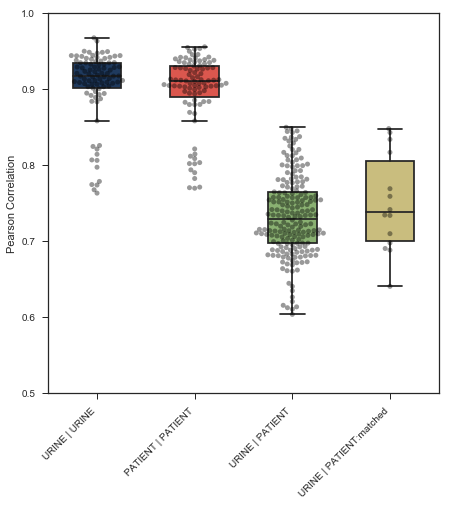

In [132]:
###
# Figure 2B: Correlation between all samples
all_corr = final_df[['all' in s for s in final_df['sample']] ]
fn = os.path.join(figures_folder, today+"_figure_2b.png")
plotCorr(all_corr, ur, uti, join, filename=fn)

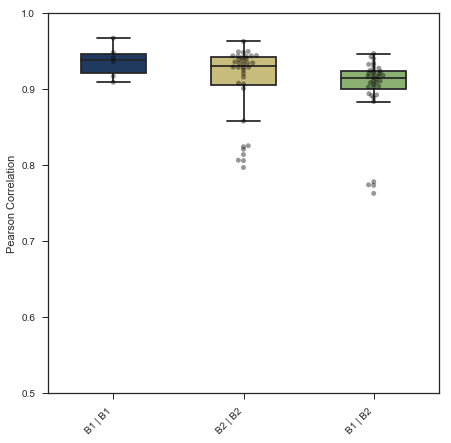

In [69]:
###
# Supplemental 2A (URINE SAMPLES)
order = ['B1_urine', 'B2_urine', 'B1_B2_urine']
labels = ["B1 | B1", "B2 | B2", "B1 | B2"]
B2_corr = final_df[[ s in order for s in final_df['sample'] ]]

plt.figure(figsize=(7,7))
ax = sns.boxplot(x = "sample", y = "pearson", data = B2_corr, order =order, palette=[col5, col2, col3, col1], 
                     width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearson", data = B2_corr,order =order, color = 'black', alpha = 0.4)
ax.set(xlabel='', ylabel='Pearson Correlation')
    
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.ylim(0.5, 1)
fn = os.path.join(figures_folder, today+"_supplemental_fig_2a.png")
plt.savefig(fn, dpi = 500, bbox_inches="tight")

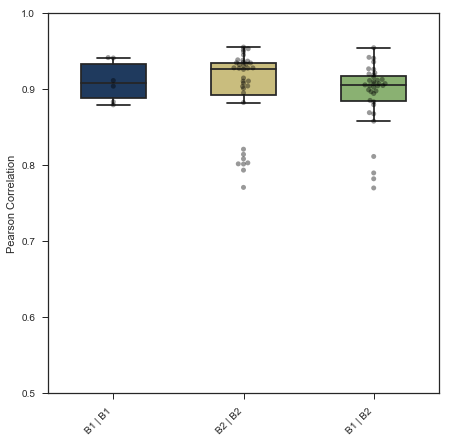

In [71]:
###
# Supplemental 2B (PATIENT SAMPLES)
order = ['B1_uti', 'B2_uti', 'B1_B2_uti']
labels = ["B1 | B1", "B2 | B2", "B1 | B2"]
B2_corr = final_df[[ s in order for s in final_df['sample'] ]]

plt.figure(figsize=(7,7))
ax = sns.boxplot(x = "sample", y = "pearson", data = B2_corr, order =order, palette=[col5, col2, col3, col1], 
                     width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearson", data = B2_corr,order =order, color = 'black', alpha = 0.4)
ax.set(xlabel='', ylabel='Pearson Correlation')
    
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.ylim(0.5, 1)
fn = os.path.join(figures_folder, today+"_supplemental_fig_2b.png")
plt.savefig(fn, dpi = 500, bbox_inches="tight")

In [87]:

def findTwoComponents(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = pd.DataFrame(data=principalComponents
                       , columns=['PC1', 'PC2'])
    pDf.set_index(df.index, inplace=True)
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, c="", nameby="", title="", filename='',
            el=False):  # , xlimits, ylimits, labels): # colorby is column in pDf
    sns.set_style("ticks")
    group = pDf[colorby].unique()

    assert len(group) < 5
    if c:
        colrs = c
    else:
        colrs = colors[:len(group) + 1]

    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, colrs):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
        ax = plt.scatter(x, y, c=c, s=150, label=g)
        if el:
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        # ax = plt.scatter(df.PC1, df.PC2, c= c, s = 150,label = g)
        plt.legend(fontsize=18, frameon=True)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, df.PC1, df.PC2):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",
                             fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), fontsize=15)
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), fontsize=15)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        if title:
            plt.title('2 component PCA', fontsize=20)
    if filename:
        fig.savefig(filename, dpi=300)
    return fig



def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


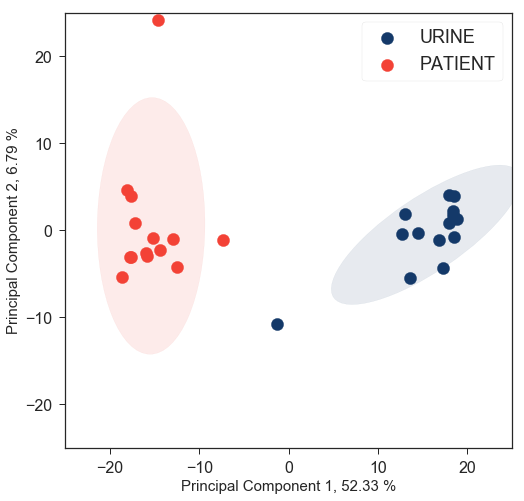

In [134]:
pDf, pc1, pc2 = findTwoComponents(cc_norm, meta)
f = plotPCA(pDf, pc1, pc2, "MEDIA", c=[col5, col1], nameby="", title="", filename='',
            el=True)

ax = f.gca()
ax.set_xlim((-25, 25))
ax.set_ylim((-25, 25))
fn = os.path.join(figures_folder, today+"_figure_2c.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")

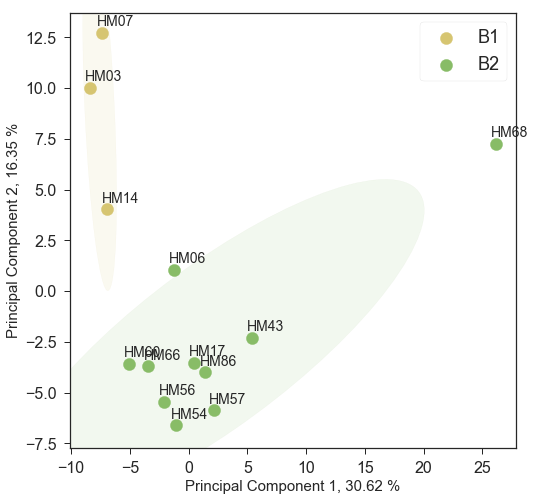

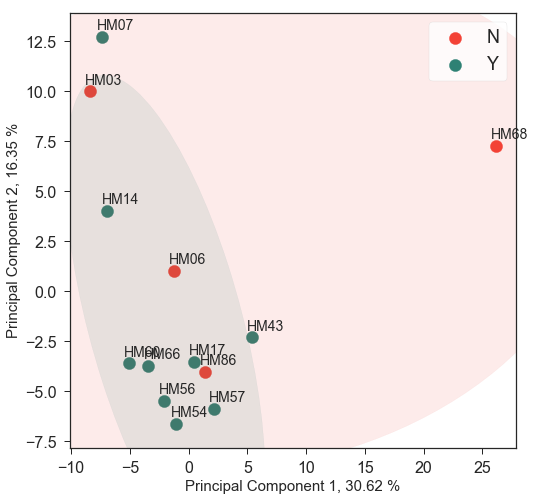

In [138]:
#URINE ALONE FOR HISTORY AND PG PCA
#REMOVE E STRAIN: Can't draw CI for 1 point (HM01)
urine_cc_norm = cc_norm[[c for c in cc_norm.columns if ur in c and not "HM01" in c]]
urine_meta = meta.loc[[c for c in urine_cc_norm.columns if ur in c]]
pDf, pc1, pc2 = findTwoComponents(urine_cc_norm, urine_meta)
pDf
f = plotPCA(pDf, pc1, pc2, "PRED_PHYLO", c=[col2, col3], nameby="STRAIN", title="", filename='',
            el=True)
fn =  os.path.join(figures_folder, today+"_supplemental_figure_2b.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")
f = plotPCA(pDf, pc1, pc2, "HISTORY", c=[col1, col4], nameby="STRAIN", title="", filename='',
            el=True)
fn =  os.path.join(figures_folder, today+"_supplemental_figure_2c.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")

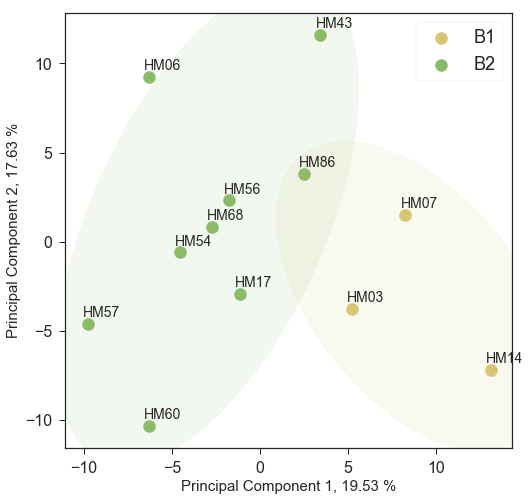

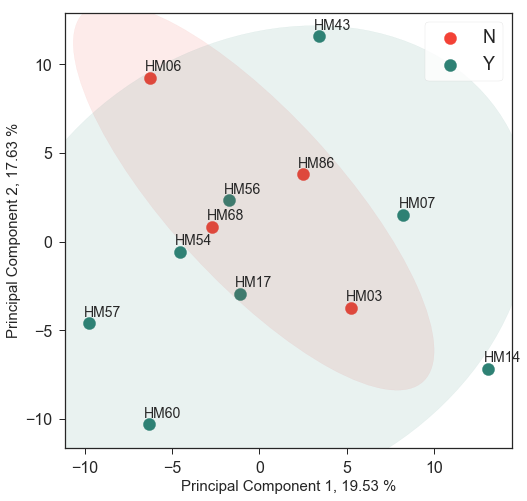

In [139]:
#PATIENT ALONE FOR HISTORY AND PG PCA
#REMOVE E STRAIN: Can't draw CI for 1 point (HM01), REMOVE HM66 because really bad
uti_cc_norm = cc_norm[[c for c in cc_norm.columns if uti in c and not "HM01" in c and not "HM66" in c]]
uti_meta = meta.loc[[c for c in uti_cc_norm.columns ]]
pDf, pc1, pc2 = findTwoComponents(uti_cc_norm, uti_meta)
pDf
f = plotPCA(pDf, pc1, pc2, "PRED_PHYLO", c=[col2, col3], nameby="STRAIN", title="", filename='',
            el=True)
fn =  os.path.join(figures_folder, today+"_supplemental_figure_2e.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")
f = plotPCA(pDf, pc1, pc2, "HISTORY", c=[col1, col4], nameby="STRAIN", title="", filename='',
            el=True)
fn =  os.path.join(figures_folder, today+"_supplemental_figure_2f.png")
f.savefig(fn, dpi = 500, bbox_inches="tight")